# QTM347 Group Project
Team members: Max Cao, Zoe Ji, Kristen Li, Bowen You

In [57]:
! pip install tensorflow
! pip install arch
! pip install keras
! pip install sklearn


# Imports
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from arch import arch_model
import statsmodels.api as sm
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, MultiHeadAttention
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [162]:
# Load Inputs
df = pd.read_csv('google_trends_5yrs.csv')

In [163]:
df.head()

,date,economics,debt,inflation,metals,sell,bonds,risk,car,leverage,...,fun,short selling,earnings,holiday,profit,kitchen,train,ring,conflict,VIX
0,12/9/2018,26,27,12,12,70,2,0,82,0,...,14,0,1,25,3,20,49,22,2,21.629999
1,12/16/2018,20,23,9,10,73,2,0,76,0,...,14,0,1,27,2,20,50,20,1,30.110001
2,12/23/2018,14,18,7,6,74,1,3,81,0,...,14,0,1,40,2,20,53,21,1,28.340000
3,12/30/2018,17,28,8,8,81,2,0,85,0,...,14,0,1,27,2,22,50,23,1,21.379999
4,1/6/2019,24,30,9,10,77,2,0,87,0,...,15,0,1,19,3,20,47,20,2,18.190001


In [164]:
features = df.iloc[:, 1:].values
vix = df.iloc[:, -1].values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [169]:
# Create sequences for LSTM training
sequence_length = 6
X, y = [], []

for i in range(len(features_scaled) - sequence_length):
    X.append(np.concatenate((features_scaled[i:i + sequence_length, :], vix[i:i + sequence_length].reshape(-1, 1)), axis=1))
    y.append(vix[i + sequence_length])
    
X, y = np.array(X), np.array(y)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [171]:
print("Shapes:")
print("(batch_size, time_steps, seq_len)")
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Shapes:
(batch_size, time_steps, seq_len)
X_train: (203, 6, 100)
y_train: (203,)
X_test: (51, 6, 100)
y_test: (51,)


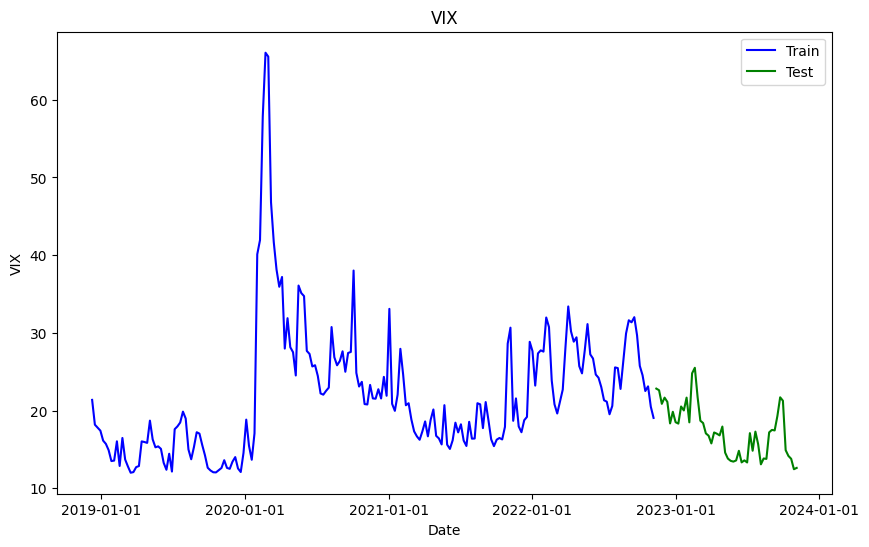

In [168]:
start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

## GARCH

In [14]:
model = arch_model(vix, vol='Garch', p=1, q=1)
results = model.fit(disp='off',show_warning = False)
residuals = results.resid
squared_residuals = residuals**2
arch_test = sm.stats.diagnostic.het_arch(squared_residuals)
print(f'ARCH test results:\n')
print(f'LM Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')
print(f'F Statistic: {arch_test[2]}')
print(f'p-value: {arch_test[3]}')

ARCH test results:

LM Statistic: 163.4958217219184
p-value: 6.145212677471604e-30
F Statistic: 45.17180807836126
p-value: 1.4360928026206865e-49


Both the LM and F tests have p-values way below the 0.05 threshold, which suggests that there is an ARCH effect to the data, and we can use ARCH models to forecast volatility.

In [15]:
model = arch_model(y_train, vol='Garch', p=1, q=1)
result = model.fit()

forecast = result.forecast(horizon=len(y_test))
forecast_values = np.sqrt(forecast.variance.values[-1, :])
y_forecasts = pd.Series(np.random.normal(0, forecast_values))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3587.0256888004656
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1073.8147432127905
Iteration:      3,   Func. Count:     20,   Neg. LLF: 698.3044772356036
Iteration:      4,   Func. Count:     26,   Neg. LLF: 671.1498994235806
Iteration:      5,   Func. Count:     32,   Neg. LLF: 665.1178563625197
Iteration:      6,   Func. Count:     37,   Neg. LLF: 662.4401153266192
Iteration:      7,   Func. Count:     42,   Neg. LLF: 662.0241184696429
Iteration:      8,   Func. Count:     47,   Neg. LLF: 661.7758979315231
Iteration:      9,   Func. Count:     52,   Neg. LLF: 661.6838160478562
Iteration:     10,   Func. Count:     57,   Neg. LLF: 661.4592744687862
Iteration:     11,   Func. Count:     62,   Neg. LLF: 661.3374836842474
Iteration:     12,   Func. Count:     67,   Neg. LLF: 661.3122854803948
Iteration:     13,   Func. Count:     72,   Neg. LLF: 661.3104157727998
Iteration:     14,   Func. Count:     77,   Neg. LLF: 661.3099

In [16]:
rmse = np.sqrt(mean_squared_error(y_test, y_forecasts))
print(f'rMSE on y_test: {rmse}')

rMSE on y_test: 20.04293018173067


## Basic LSTM Model

In [172]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 64)                42240     
                                                                 
 dense_82 (Dense)            (None, 1)                 65        
                                                                 
Total params: 42305 (165.25 KB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [173]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/1000
5/5 [==============================] - 1s 44ms/step - loss: 478.4598 - root_mean_squared_error: 21.8737 - val_loss: 511.6098 - val_root_mean_squared_error: 22.6188
Epoch 2/1000
5/5 [==============================] - 0s 4ms/step - loss: 435.0935 - root_mean_squared_error: 20.8589 - val_loss: 461.2924 - val_root_mean_squared_error: 21.4777
Epoch 3/1000
5/5 [==============================] - 0s 4ms/step - loss: 395.0084 - root_mean_squared_error: 19.8748 - val_loss: 414.6267 - val_root_mean_squared_error: 20.3624
Epoch 4/1000
5/5 [==============================] - 0s 5ms/step - loss: 359.0827 - root_mean_squared_error: 18.9495 - val_loss: 371.6183 - val_root_mean_squared_error: 19.2774
Epoch 5/1000
5/5 [==============================] - 0s 5ms/step - loss: 327.8285 - root_mean_squared_error: 18.1060 - val_loss: 334.4326 - val_root_mean_squared_error: 18.2875
Epoch 6/1000
5/5 [==============================] - 0s 5ms/step - loss: 299.5750 - root_mean_squared_error: 17.3082 - v

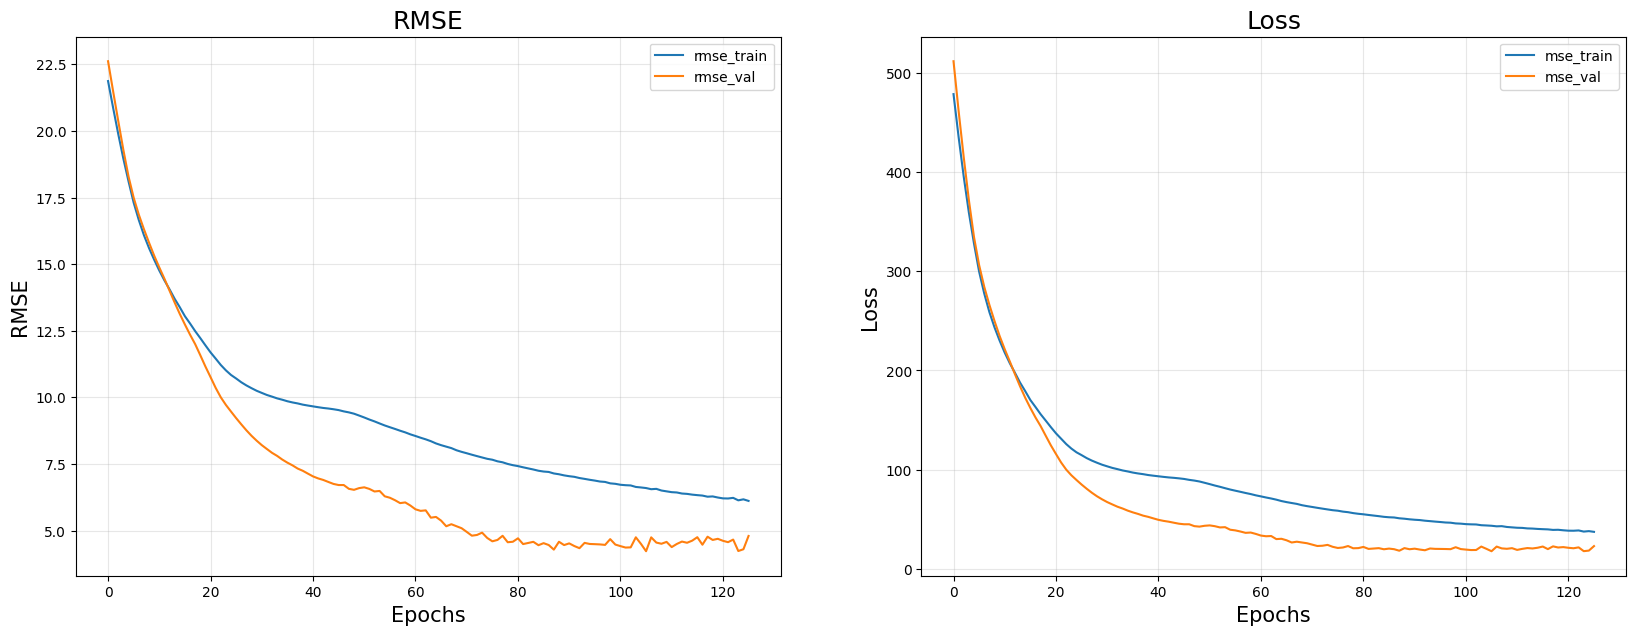

In [174]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse_train")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "rmse_val")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="mse_train")
plt.plot(history.epoch, history.history['val_loss'], label="mse_val")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [175]:
# Model Evaluation
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss}')

2/2 [==============================] - 0s 2ms/step - loss: 7.8186 - root_mean_squared_error: 2.7962
Test MSE: [7.818598747253418, 2.796175718307495]


2/2 [==============================] - 0s 3ms/step


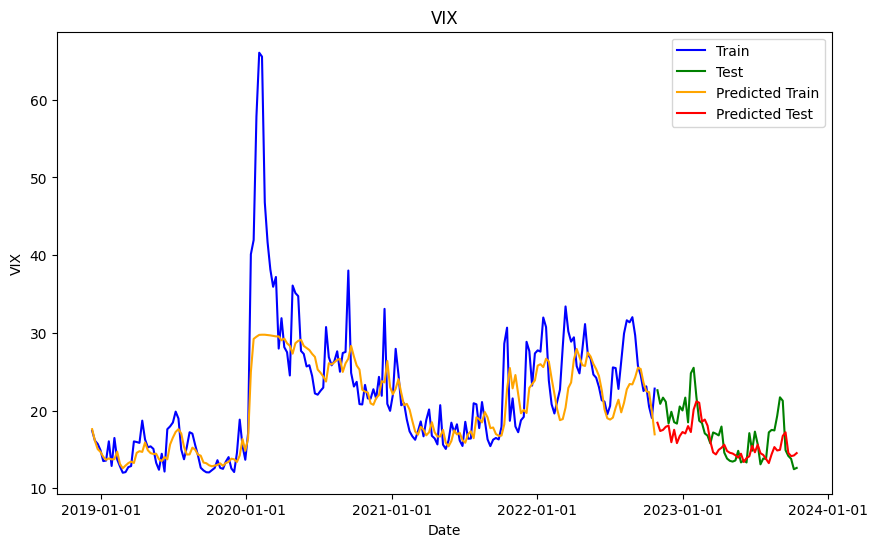

In [176]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')
plt.plot(indices_train_dates, train_predictions, label='Predicted Train', color='orange')
plt.plot(indices_test_dates, test_predictions, label='Predicted Test', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

## Extended Model

In [177]:
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(units=10, activation='relu'))
model.add(GRU(units=10))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 6, 64)             42240     
                                                                 
 dropout_30 (Dropout)        (None, 6, 64)             0         
                                                                 
 dense_83 (Dense)            (None, 6, 10)             650       
                                                                 
 gru_16 (GRU)                (None, 10)                660       
                                                                 
 dropout_31 (Dropout)        (None, 10)                0         
                                                                 
 dense_84 (Dense)            (None, 1)                 11        
                                                                 
Total params: 43561 (170.16 KB)
Trainable params: 435

In [178]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/1000
5/5 [==============================] - 1s 75ms/step - loss: 515.3613 - root_mean_squared_error: 22.7016 - val_loss: 571.7991 - val_root_mean_squared_error: 23.9123
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 495.0660 - root_mean_squared_error: 22.2501 - val_loss: 550.7495 - val_root_mean_squared_error: 23.4681
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 478.6656 - root_mean_squared_error: 21.8784 - val_loss: 533.7947 - val_root_mean_squared_error: 23.1040
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 463.1600 - root_mean_squared_error: 21.5212 - val_loss: 519.3755 - val_root_mean_squared_error: 22.7898
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 450.2978 - root_mean_squared_error: 21.2202 - val_loss: 504.2763 - val_root_mean_squared_error: 22.4561
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 436.2435 - root_mean_squared_error: 20.8864 - v

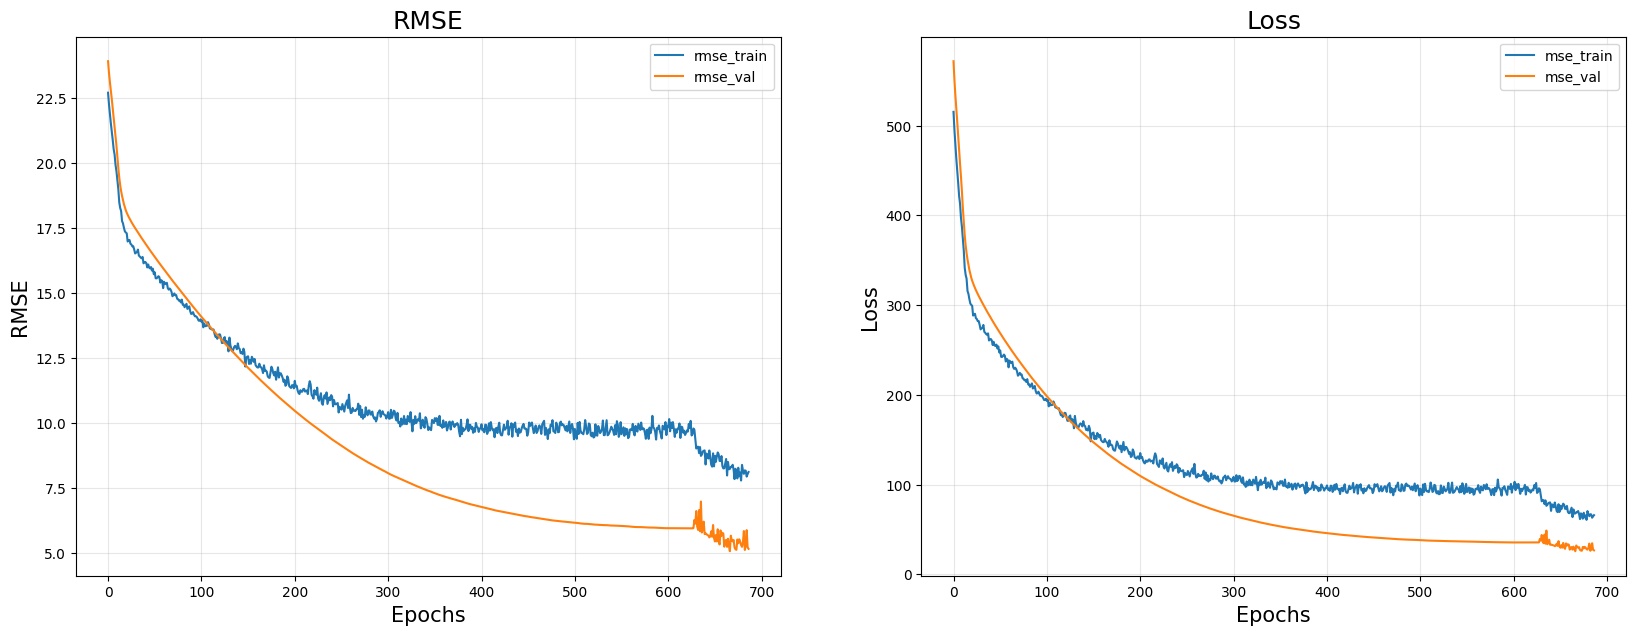

In [179]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse_train")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "rmse_val")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="mse_train")
plt.plot(history.epoch, history.history['val_loss'], label="mse_val")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [180]:
# Model Evaluation
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss}')

2/2 [==============================] - 0s 2ms/step - loss: 9.8671 - root_mean_squared_error: 3.1412
Test MSE: [9.8671236038208, 3.141197681427002]


1/7 [===>..........................] - ETA: 0s

2/2 [==============================] - 0s 2ms/step


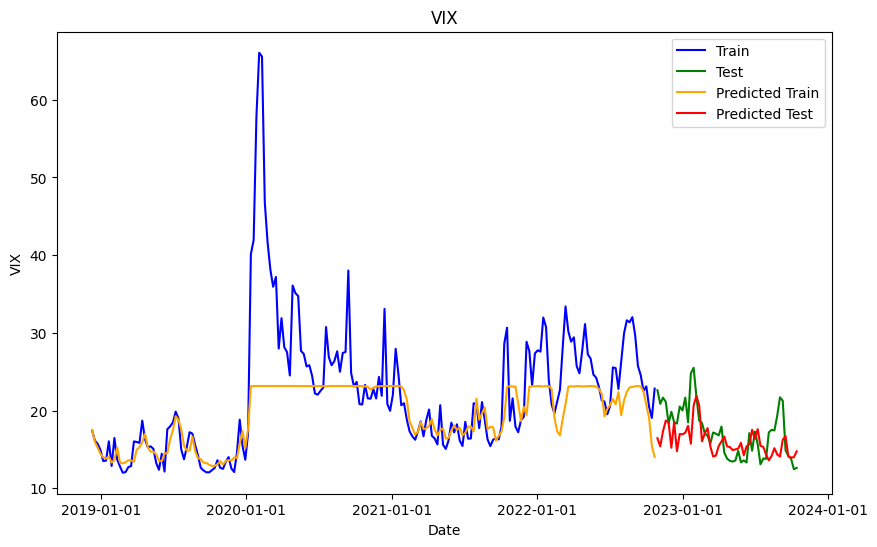

In [182]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')
plt.plot(indices_train_dates, train_predictions, label='Predicted Train', color='orange')
plt.plot(indices_test_dates, test_predictions, label='Predicted Test', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

In [183]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, MultiHeadAttention, Dropout, Dense, GRU
from tensorflow.keras.models import Model

# Assuming X_train has shape (batch_size, sequence_length, input_dim)
input_shape = X_train.shape[1:]

# Define the input layer
inputs = Input(shape=input_shape)

# LSTM layer
x = LSTM(units=64, return_sequences=True)(inputs)

# MultiHeadAttention layer
x = MultiHeadAttention(num_heads=1, key_dim=1)(x, x, x)

# Dense layer
x = Dense(units=10, activation='relu')(x)

# GRU layer
x = GRU(units=10)(x)

# Output layer
outputs = Dense(units=1, activation='linear')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Display model summary
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 6, 100)]             0         []                            
                                                                                                  
 lstm_60 (LSTM)              (None, 6, 64)                42240     ['input_10[0][0]']            
                                                                                                  
 multi_head_attention_6 (Mu  (None, 6, 64)                323       ['lstm_60[0][0]',             
 ltiHeadAttention)                                                   'lstm_60[0][0]',             
                                                                     'lstm_60[0][0]']             
                                                                                            

In [184]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
history = model.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/1000
5/5 [==============================] - 1s 78ms/step - loss: 538.0056 - root_mean_squared_error: 23.1949 - val_loss: 612.9785 - val_root_mean_squared_error: 24.7584
Epoch 2/1000
5/5 [==============================] - 0s 6ms/step - loss: 533.7485 - root_mean_squared_error: 23.1030 - val_loss: 605.5428 - val_root_mean_squared_error: 24.6078
Epoch 3/1000
5/5 [==============================] - 0s 6ms/step - loss: 525.7695 - root_mean_squared_error: 22.9297 - val_loss: 592.8087 - val_root_mean_squared_error: 24.3477
Epoch 4/1000
5/5 [==============================] - 0s 6ms/step - loss: 513.1559 - root_mean_squared_error: 22.6529 - val_loss: 574.1347 - val_root_mean_squared_error: 23.9611
Epoch 5/1000
5/5 [==============================] - 0s 6ms/step - loss: 495.7147 - root_mean_squared_error: 22.2647 - val_loss: 551.3137 - val_root_mean_squared_error: 23.4801
Epoch 6/1000
5/5 [==============================] - 0s 6ms/step - loss: 476.2136 - root_mean_squared_error: 21.8223 - v

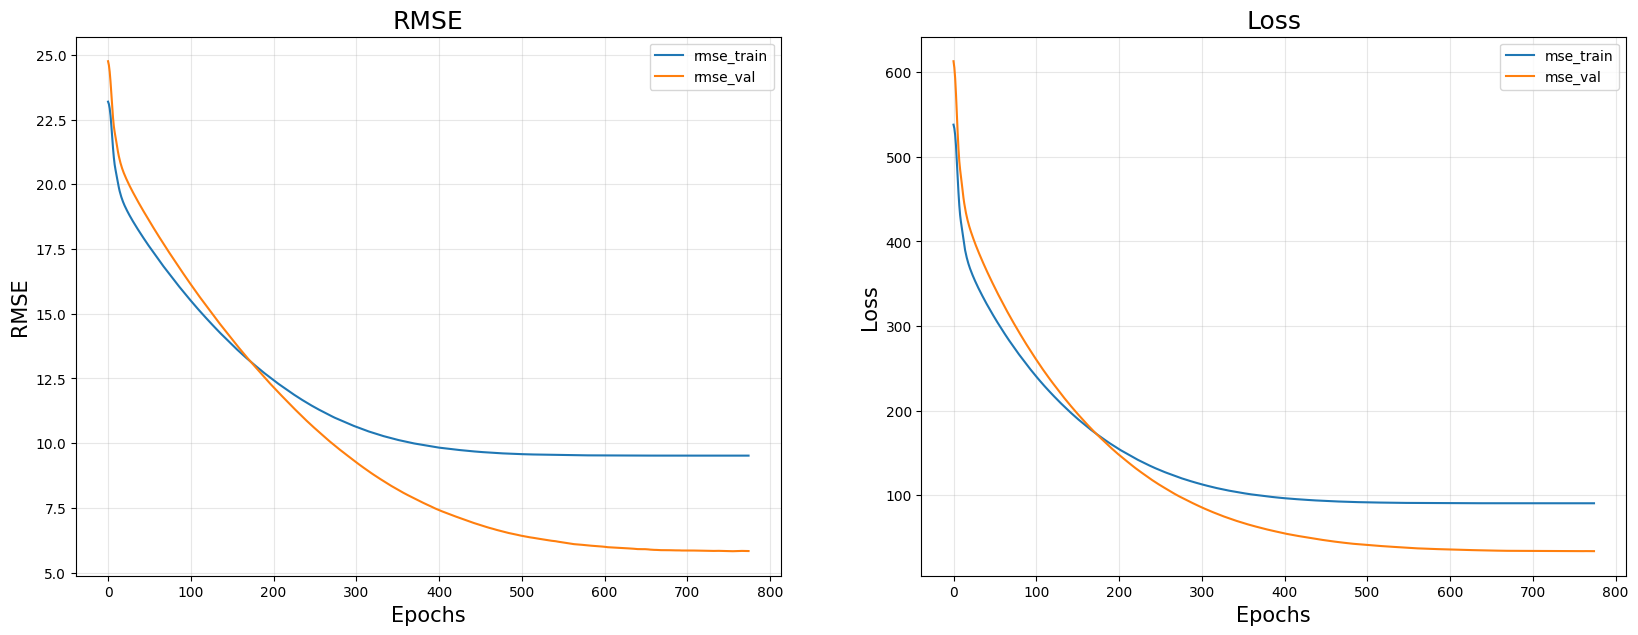

In [185]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse_train")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "rmse_val")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="mse_train")
plt.plot(history.epoch, history.history['val_loss'], label="mse_val")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [186]:
# Model Evaluation
loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {loss}')

2/2 [==============================] - 0s 2ms/step - loss: 25.2617 - root_mean_squared_error: 5.0261
Test MSE: [25.26166534423828, 5.026098251342773]


2/2 [==============================] - 0s 2ms/step


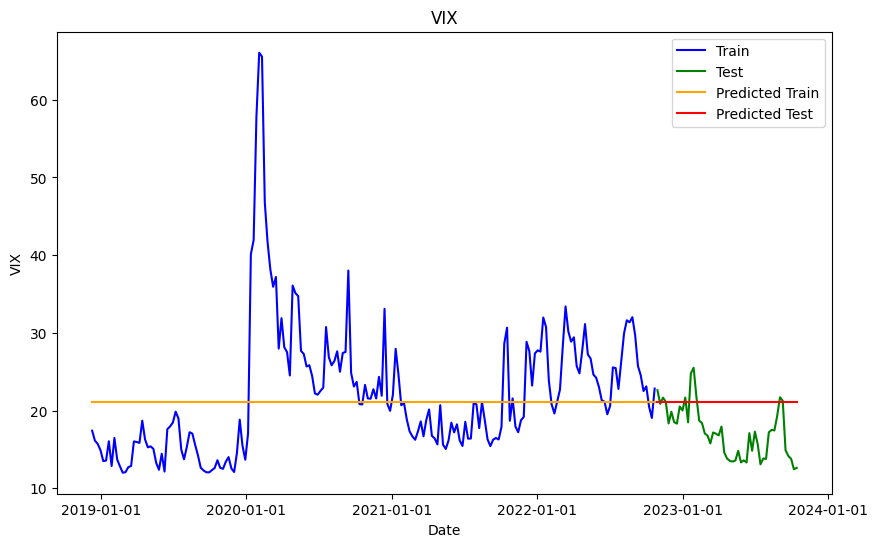

In [187]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

start_date = datetime(2018, 12, 9)
indices_train_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train))]
indices_test_dates = [start_date + timedelta(weeks=i) for i in range(len(y_train), len(y_train) + len(y_test))]

plt.figure(figsize=(10, 6))
plt.plot(indices_train_dates, y_train, label='Train', color='blue')
plt.plot(indices_test_dates, y_test, label='Test', color='green')
plt.plot(indices_train_dates, train_predictions, label='Predicted Train', color='orange')
plt.plot(indices_test_dates, test_predictions, label='Predicted Test', color='red')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('VIX')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

In [105]:
!pip install optuna

  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/05/3c/e9715756751e56f7df4b64c999650f418f6b48f73a824bbfe8e3604385e2/optuna-3.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/d5/d8/fc331ad9aa5f2a551042582c3ededd70ee4e72b032089b1784150a5704ac/alembic-1.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/95/df/520663eb7f7a329f7c585834b754bcc3cbcc03957d85fcbba4a2a723ad9d/colorlog-6.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for sqlalchemy>=1.3.0 from https://files.pythonhosted.org/packages/c7/55/d1d2ad054fb7e9188681d56df40ed81c2c198314a805b180b0ec99019da1/SQLAlchemy-2.0.23-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/24/3b/11fe92d68c6a42468ddab0cf03f454419b0788fff4e91ba46b8bebafeffd/Mako-1.3.

In [117]:
import torch
import optuna

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3, 5)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_l{i}', 4, 128)
        layers.append(torch.nn.Linear(in_features, out_features))
        layers.append(torch.nn.ReLU())
        in_features = out_features
    layers.append(torch.nn.Linear(in_features, 10))
    layers.append(torch.nn.LogSoftmax(dim=1))
    model = torch.nn.Sequential(*layers).to(torch.device('cpu'))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    loss = model.evaluate(X_test, y_test)

    return loss[0]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 10)

[I 2023-12-04 15:03:16,249] A new study created in memory with name: no-name-5fdb0ed9-dd4b-45ec-a8dc-941814d14413
[W 2023-12-04 15:03:16,253] Trial 0 failed with parameters: {'n_layers': 1, 'n_units_l0': 60} because of the following error: AttributeError("'Sequential' object has no attribute 'compile'").
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/kk/l7dkgxgn6wn9zsh2ly34fdkr0000gn/T/ipykernel_39297/3414952012.py", line 18, in objective
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    ^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1614, in __getattr__
    raise AttributeError("'{}' object has no attribute '{}'".format(
AttributeEr

AttributeError: 'Sequential' object has no attribute 'compile'

In [111]:
trial = study.best_trial

In [112]:
trial

FrozenTrial(number=6, state=1, values=[285.7627258300781], datetime_start=datetime.datetime(2023, 12, 4, 14, 57, 59, 858232), datetime_complete=datetime.datetime(2023, 12, 4, 14, 58, 0, 81999), params={}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={}, trial_id=6, value=None)

In [113]:
study.best_params

{}

In [202]:
from tensorflow.keras.datasets import mnist

In [203]:
N_TRAIN_EXAMPLES = 3000
N_VALID_EXAMPLES = 1000
BATCHSIZE = 128
CLASSES = 10
EPOCHS = 1

In [204]:
def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model

In [205]:
def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [206]:
def learn(model, optimizer, dataset, mode="eval"):
    accuracy = tf.metrics.Accuracy("accuracy", dtype=tf.float32)

    for batch, (images, labels) in enumerate(dataset):
        with tf.GradientTape() as tape:
            logits = model(images, training=(mode == "train"))
            loss_value = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
            )
            if mode == "eval":
                accuracy(
                    tf.argmax(logits, axis=1, output_type=tf.int64), tf.cast(labels, tf.int64)
                )
            else:
                grads = tape.gradient(loss_value, model.variables)
                optimizer.apply_gradients(zip(grads, model.variables))

    return accuracy

In [207]:
def get_mnist():
    (x_train, y_train), (x_valid, y_valid) = mnist.load_data()
    x_train = x_train.astype("float32") / 255
    x_valid = x_valid.astype("float32") / 255

    y_train = y_train.astype("int32")
    y_valid = y_valid.astype("int32")

    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.shuffle(60000).batch(BATCHSIZE).take(N_TRAIN_EXAMPLES)

    valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    valid_ds = valid_ds.shuffle(10000).batch(BATCHSIZE).take(N_VALID_EXAMPLES)
    return train_ds, valid_ds

In [212]:
def objective(trial):
    # Get MNIST data.
    train_ds = X_train
    valid_ds = X_test

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/cpu:0"):
        for _ in range(EPOCHS):
            learn(model, optimizer, train_ds, "train")

        accuracy = learn(model, optimizer, valid_ds, "eval")

    # Return last validation accuracy.
    return accuracy.result()

In [215]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-12-04 15:38:10,294] A new study created in memory with name: no-name-874bf2fb-77b5-445a-8b23-25a6337a67b0
[W 2023-12-04 15:38:10,303] Trial 0 failed with parameters: {'n_layers': 1, 'weight_decay': 3.245322834822255e-10, 'n_units_l0': 4, 'optimizer': 'Adam', 'adam_learning_rate': 2.600210556761026e-05} because of the following error: ValueError('too many values to unpack (expected 2)').
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/kk/l7dkgxgn6wn9zsh2ly34fdkr0000gn/T/ipykernel_39297/1046546231.py", line 13, in objective
    learn(model, optimizer, train_ds, "train")
  File "/var/folders/kk/l7dkgxgn6wn9zsh2ly34fdkr0000gn/T/ipykernel_39297/1538200137.py", line 4, in learn
    for batch, (images, labels) in enumerate(dataset):
               ^^^^^^^^^^^^^^^^
ValueErr

ValueError: too many values to unpack (expected 2)